In [92]:
import os 
import numpy as np 
import pandas as pd 
import glob
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import torch
from torch import nn
from torch.nn import functional as nnf
from torchvision.models import resnet18
import time

In [93]:
!git clone 'https://github.com/frompotenza/SidewalkSegmentation'

fatal: destination path 'SidewalkSegmentation' already exists and is not an empty directory.


In [94]:
path_images = '/kaggle/working/SidewalkSegmentation/Dataset'

In [95]:
org_image_list = []
for filename in sorted(glob.glob("/kaggle/working/SidewalkSegmentation/dataset_segmented/*")): 
    if filename.lower().endswith(('.png', '.jpg')): 
        im=Image.open(filename)
        im=np.array(im)
        org_image_list.append(im)

In [96]:
seg_image_list = []
for filename in sorted(glob.glob("/kaggle/working/SidewalkSegmentation/segmented_images/*")): 
    if filename.lower().endswith(('.png', '.jpg')): 
        im=Image.open(filename)
        im=np.array(im)
        seg_image_list.append(im)

In [97]:
shp_arr = [np.shape(org_image_list[i]) for i in range(len(org_image_list))]
print(shp_arr[:10])

[(640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3), (640, 640, 3)]


In [98]:
def extract_green_mask(image_rgb):

    green_mask = (
        (image_rgb[:, :, 0] == 0) &  
        (image_rgb[:, :, 1] == 255) &  
        (image_rgb[:, :, 2] == 0)    
    )
    
    return green_mask.astype(np.uint8)  

In [99]:
seg_image_list = [extract_green_mask(seg_image_list[i]) for i in range(len(seg_image_list))]

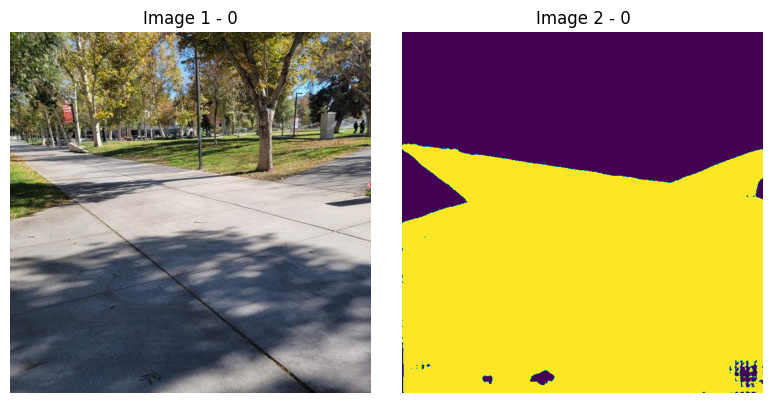

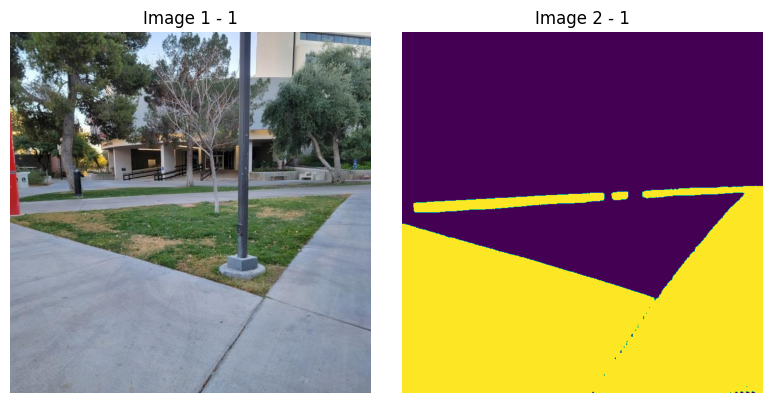

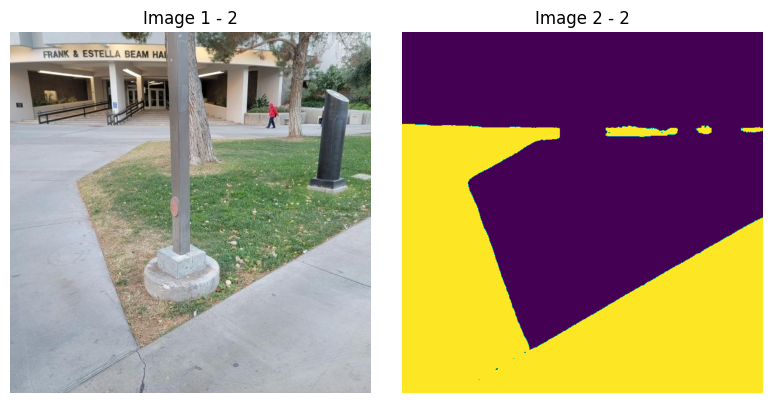

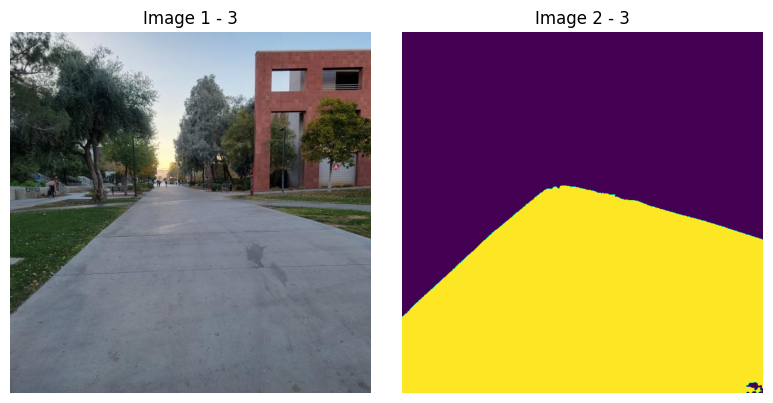

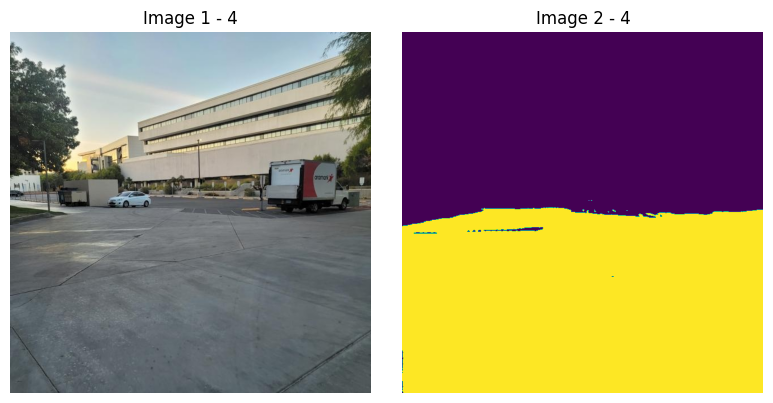

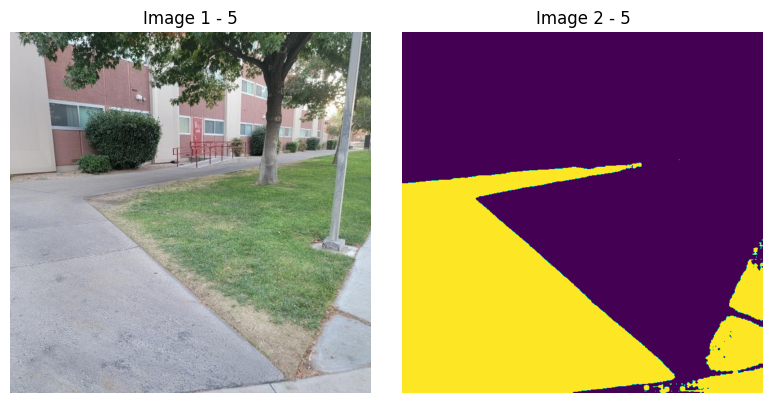

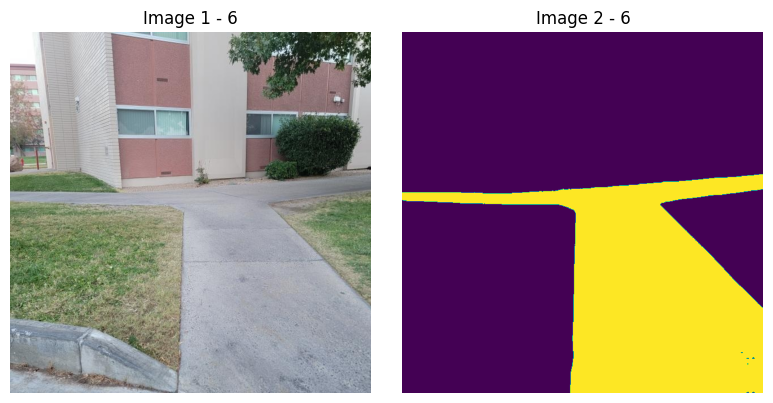

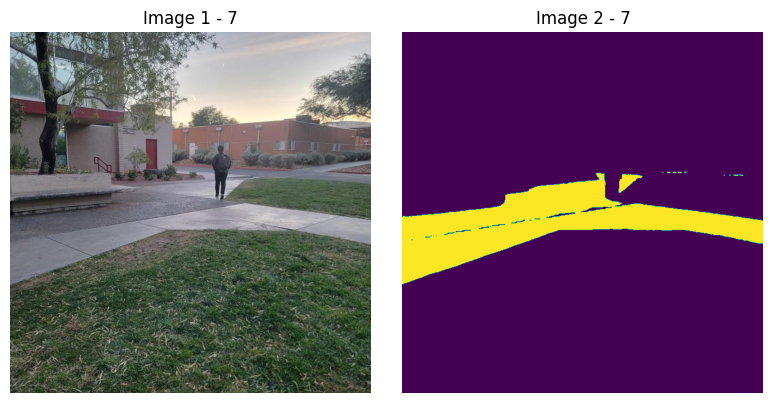

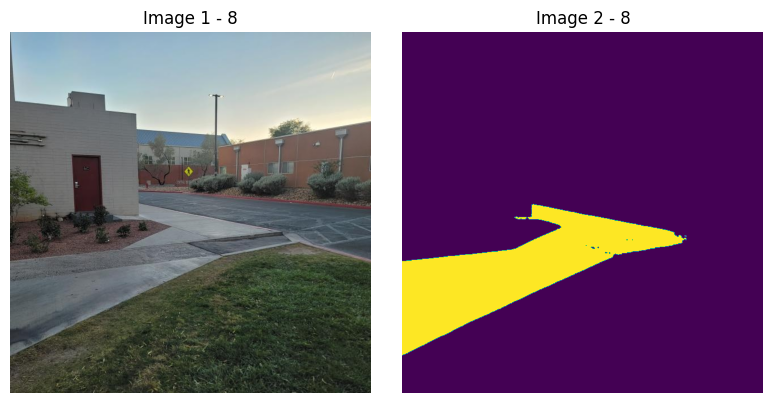

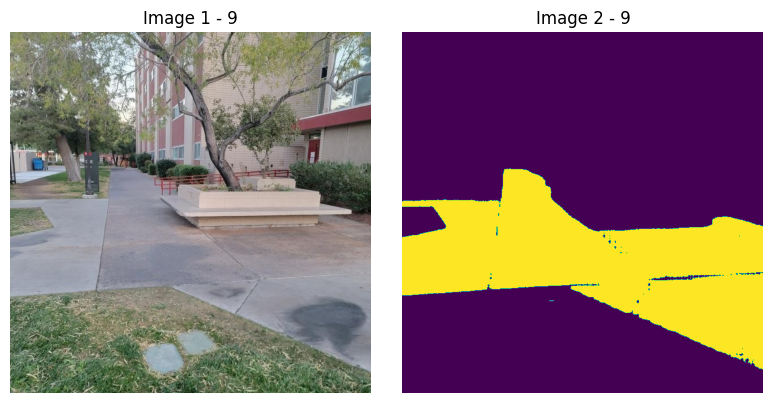

In [100]:
for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    ax1.imshow(org_image_list[i])
    ax1.set_title(f'Image 1 - {i}')
    ax1.axis('off')
    
    ax2.imshow(seg_image_list[i])
    ax2.set_title(f'Image 2 - {i}')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

In [101]:

class UBlock(nn.Module):
    def __init__(self, in_channels,posi="Left"):
        ####################
        super().__init__()
        in_channels=int(in_channels)
        if posi=="Left":
            if in_channels == 1 or in_channels == 2 or in_channels == 3:
                out_channels = 64 
            else:
                out_channels = int(2*in_channels)
            self.Block = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU()
            )
        else:
            out_channels = int(in_channels//2)
            self.Block = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,(3,3),device=device,padding="same"),
                nn.ReLU(),
                nn.ConvTranspose2d(out_channels,out_channels//2,(2,2),device=device,stride=2)
            )
            
            
            
            
    def forward(self, x):
        return self.Block(x)



class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.Pool=nn.MaxPool2d((2,2))
        
        self.Left = nn.Sequential(
            UBlock(in_channels)
        )
        out = 64
        for i in range(3):
            self.Left.append(UBlock(out))
            out*=2
        self.Bottom = nn.Sequential(
            UBlock(out),
            nn.ConvTranspose2d(int(out*2),int(out),(2,2),device=device,stride=2)
        )
            
            
        self.Right = nn.Sequential(
            UBlock(1024,"Right")
        )
        out = 512
        for i in range(2):
            self.Right.append(UBlock(out,"Right"))
            out//=2
            
            
        self.out=nn.Sequential(
            nn.Conv2d(out,out//2,(3,3),device=device,padding="same"),
            nn.ReLU(),
            nn.Conv2d(out//2,out//2,(3,3),device=device,padding="same"),
            nn.ReLU(),
            nn.Conv2d(out//2,out_channels,(1,1),device=device,padding="same")
        )
            
    def forward(self, x):
        left_values=[]
        while x.ndim > 4:
            x = x[0]
        for i in self.Left:
            left_values.append(i(x))
            x=i(x)
            x=self.Pool(x)
        x=self.Bottom(x)
        
        l=len(self.Right)
        for i in range(l):
            x=torch.cat((left_values[l-i],x),-3)
            x=self.Right[i](x)
        x=torch.cat((left_values[0],x),-3)
        return self.out(x)
        


In [129]:
first = org_image_list[0]
first = first[None, :]
print(first.shape)

for i in range(1, 60):
    first = np.concatenate((first, org_image_list[i][None, :]), axis=0)
    

(1, 640, 640, 3)


In [130]:
first_seg = seg_image_list[0]
first_seg = first_seg[None, :]
print(first_seg.shape)

for i in range(1, 60):
    first_seg = np.concatenate((first_seg, seg_image_list[i][None, :]), axis=0)

(1, 640, 640)


In [131]:
images = first
binary_masks = first_seg 

In [138]:
device = "cuda"

SemNet = UNet(3,1).to(device)

In [141]:
epo = 80

opt = torch.optim.Adam(SemNet.parameters(), lr=1e-4)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(opt,epo)
lossfunc = nn.BCEWithLogitsLoss()
#loss = 
losses = []
print(images.shape)
print(binary_masks.shape)
masks_tensor = torch.tensor(binary_masks).float().cuda()
images_tensor = torch.tensor(images).permute((0,3,1,2)).float()[:,None,:].cuda()
print(images_tensor.shape)
print(masks_tensor.shape)
#sem = np.where(orig>0,1,0)
start=time.time()
for i_epoch in range(epo):
    for i in range(60):
        pred = SemNet(images_tensor[i])
        opt.zero_grad()
        loss = lossfunc(pred.squeeze(), masks_tensor[i].squeeze())
            
        loss.backward()
        
        opt.step()
        
        losses += [float(loss)]
    scheduler.step()
    if (i_epoch+1)%20==0:  
        print("loss: "+str(np.mean(losses))+" epoch "+str(i_epoch+1))
    losses = []
print("Semantic Net DONE")
print(time.time()-start)


(60, 640, 640, 3)
(60, 640, 640)
torch.Size([60, 1, 3, 640, 640])
torch.Size([60, 640, 640])
loss: 0.285714087014397 epoch 20
loss: 0.09231233994166056 epoch 40
loss: 0.06527815454949935 epoch 60
loss: 0.0199689372908324 epoch 80
Semantic Net DONE
2324.3880574703217


In [1]:
eval_seg = org_image_list[11]
eval_seg = eval_seg[None, :]
#print(first_seg.shape)

for i in range(62, 71):
    eval_seg = np.concatenate((eval_seg, org_image_list[i][None, :]), axis=0)

NameError: name 'org_image_list' is not defined

In [108]:
SemNet.eval()
Sem_cpu = SemNet.to(device)

In [126]:
eval_seg_pred = torch.tensor(eval_seg[1]).permute((2,0,1)).float()[None,:].to(device)
pred_sem_pred = Sem_cpu(eval_seg_pred)

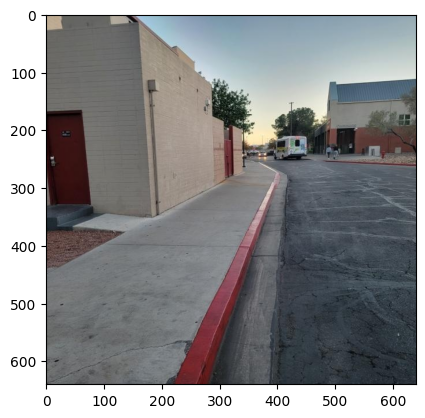

In [127]:
plt.imshow(org_image_list[12])

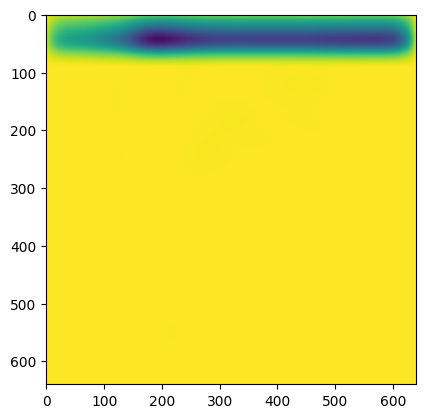

In [128]:

plt.imshow(pred_sem_pred.squeeze().cpu().detach().numpy())